# seq2seq를 이용해서 번역기 만들기
1.교사강요를 위한 모델로 학습시킴
2.학습시킨 것 중에 인코더 모델 예측, 디코더의 임베딩 벡터를 재사용해서 테스트 모델을 다시 만듬
* 인코더 모델 예측이란? 인코더 마지막 부분의 은닉상태와 셀상태를 의미 함
* LSTM의 리턴값으로 아웃풋(각시점의 은닉상태), 마지막 은닉상태, 마지막 셀상태를 리턴함
* LSTM의 return_sequences가 True 리턴값중에서 아웃풋(각시점의 은닉상태)이 각시점마다 다 출력됨. 배열로
* LSTM의 return_sequences가 False이면 아웃풋과 마지막 은닉상태는 동일값이다. 왜냐하면 False이기 때문에 아웃풋이 마지막값만 표시됨.
* LSTM의 return_state를 참으로 하면 마지막 은닉상태와 셀상태를 마지막에 한번 출력 함 


In [61]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.chdir(r"c:\projects\PY_MLE")

import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from gensim.models.doc2vec import TaggedDocument

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling1D, SimpleRNN, Embedding, Masking
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import sentencepiece as spm
import urllib.request
import csv
import unicodedata
from tensorflow.keras.utils import plot_model, to_categorical

In [62]:
# 데이터를 이만큼만 사용하겠다는 의미
num_samples = 33000

# 악센트 제거
def to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

# 악센트 제거 함수 호출
def preprocess_sentence(sent):
    sent = to_ascii(sent.lower())
    
    # 아래 특수문자 사이에 구두점 추가
    sent = re.sub(r"([?.!,¿])", r" \1", sent)
    
    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
    
    sent = re.sub(r"\s+", r" ", sent)
    
    return sent

In [63]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print(en_sent)
print(preprocess_sentence(en_sent))

print(fr_sent)
print(preprocess_sentence(fr_sent))


Have you had dinner?
have you had dinner ?
Avez-vous déjà diné?
avez vous deja dine ?


In [64]:
# 교사강요를 위하여 decoder 입력값과 실제값 분리
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split("\t")

            # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [65]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print("인코더의 입력: ", sents_en_in[:5])
print("디코더의 입력: ", sents_fra_in[:5])
print("디코더의 레이블: ", sents_fra_out[:5])


인코더의 입력:  [['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
디코더의 입력:  [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
디코더의 레이블:  [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


In [66]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [67]:
# 단어집합의 크기
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print(src_vocab_size, tar_vocab_size)

4606 8107


In [68]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word


In [69]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)


encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


랜덤 시퀀스 : [27682  4892  7873 ... 18213 16435  7761]


In [70]:
# 테스트데이터 분리
n_of_val = int(33000*0.1)
print(n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


3300


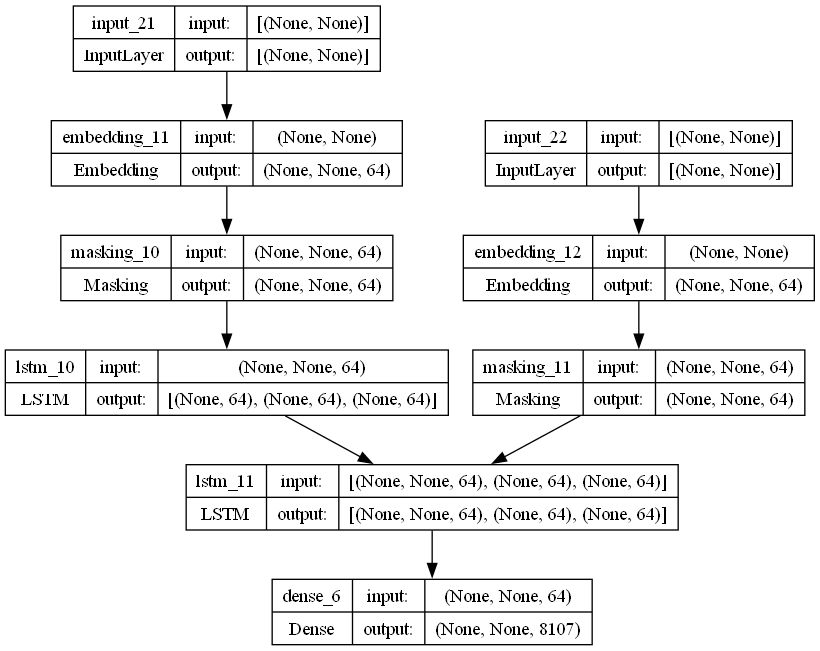

In [71]:
embedding_dim = 64
hidden_units = 64

# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장


# 디코더
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])


plot_model(model, to_file='140102.png',show_shapes=True)

In [72]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)


Epoch 1/50
233/233 [==============================] - 34s 119ms/step - loss: 3.4477 - acc: 0.6107 - val_loss: 2.0826 - val_acc: 0.6161
Epoch 2/50
233/233 [==============================] - 25s 109ms/step - loss: 1.8966 - acc: 0.6789 - val_loss: 1.7770 - val_acc: 0.7373
Epoch 3/50
233/233 [==============================] - 26s 110ms/step - loss: 1.6858 - acc: 0.7411 - val_loss: 1.6308 - val_acc: 0.7489
Epoch 4/50
233/233 [==============================] - 25s 109ms/step - loss: 1.5606 - acc: 0.7523 - val_loss: 1.5236 - val_acc: 0.7587
Epoch 5/50
233/233 [==============================] - 26s 111ms/step - loss: 1.4526 - acc: 0.7654 - val_loss: 1.4287 - val_acc: 0.7738
Epoch 6/50
233/233 [==============================] - 25s 109ms/step - loss: 1.3568 - acc: 0.7805 - val_loss: 1.3491 - val_acc: 0.7883
Epoch 7/50
233/233 [==============================] - 25s 109ms/step - loss: 1.2771 - acc: 0.7946 - val_loss: 1.2865 - val_acc: 0.7966
Epoch 8/50
233/233 [==============================] - 2

# 테스트를 위한 재설계
# 위에서는 학습을 위한 것이었고(교사강요 학습)

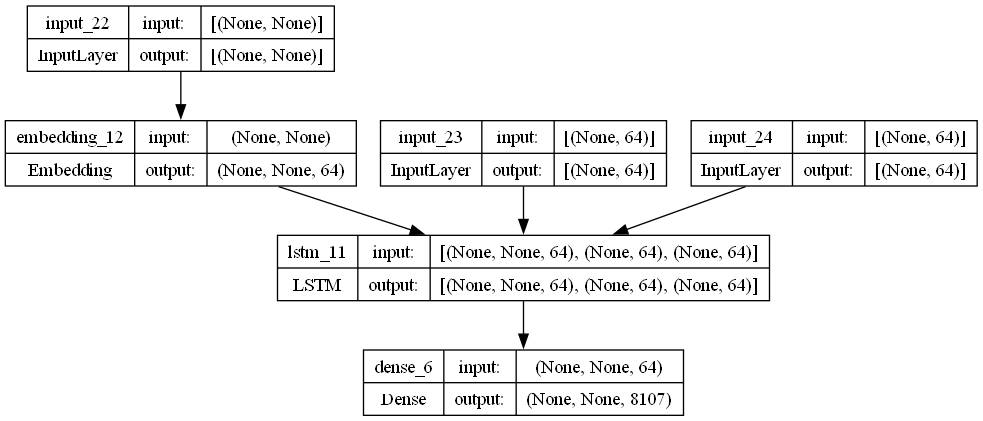

In [73]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


plot_model(decoder_model, to_file='140102_1.png',show_shapes=True)





In [76]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_to_index["<sos>"]

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += " " + sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if sampled_char == "<eos>" or len(decoded_sentence) > 50:
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [77]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ""
    for encoded_word in input_seq:
        if encoded_word != 0:
            sentence = sentence + index_to_src[encoded_word] + " "
    return sentence


# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ""
    for encoded_word in input_seq:
        if (
            encoded_word != 0
            and encoded_word != tar_to_index["<sos>"]
            and encoded_word != tar_to_index["<eos>"]
        ):
            sentence = sentence + index_to_tar[encoded_word] + " "
    return sentence

In [78]:
for seq_index in [3, 50, 100, 300, 1001]:
    input_seq = encoder_input_train[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("입력문장 :", seq_to_src(encoder_input_train[seq_index]))
    print("정답문장 :", seq_to_tar(decoder_input_train[seq_index]))
    print("번역문장 :", decoded_sentence[1:-5])
    print("-" * 50)

1/1 [==============================] - 0s 17ms/step
입력문장 : you can t go alone . 
정답문장 : tu ne peux pas y aller seule . 
번역문장 : tu ne peux pas partir ? 
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : i have a pain here . 
정답문장 : j ai mal ici . 
번역문장 : j ai la baraka . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : that s how it is . 
정답문장 : c est comme ca . 
번역문장 : c est cette reponse . 
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : come up here . 
정답문장 : approche . 
번역문장 : venez ici . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : tom stayed behind . 
정답문장 : tom restait en retrait . 
번역문장 : tom est parti . 
--------------------------------------------------


In [79]:
for seq_index in [3, 50, 100, 300, 1001]:
    input_seq = encoder_input_test[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("입력문장 :", seq_to_src(encoder_input_test[seq_index]))
    print("정답문장 :", seq_to_tar(decoder_input_test[seq_index]))
    print("번역문장 :", decoded_sentence[1:-5])
    print("-" * 50)

1/1 [==============================] - 0s 18ms/step
입력문장 : we meant well . 
정답문장 : nos intentions etaient bonnes . 
번역문장 : nous sommes tres bien ? 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : he carried a cane . 
정답문장 : il portait une canne . 
번역문장 : il tient un calin a son succes . 
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : i ll leave . 
정답문장 : je partirai . 
번역문장 : j irai en avant . 
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : tom denied it . 
정답문장 : tom l a dementi . 
번역문장 : tom l a escroquee . 
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : i heard about it . 
정답문장 : j en ai entendu parler . 
번역문장 : j ai entendu le mien . 
--------------------------------------------------
